<a href="https://colab.research.google.com/github/NivedyaSheej/StackGAN/blob/main/Copy_of_Attempt2_Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Stage I GAN**

so my inputs are a csv file with 2 columns- filename, caption as a bert embedding
and a folder with a bunch of image files with the pictures of hills against a white background.
using these 2 inputs i need to make a text to image gan

#**Importing Libraries**

In [1]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [ ]:
#mount drive

#**Importing the github repo with the data**

In [2]:
import zipfile
import os

In [3]:
!wget --no-check-certificate \
    "https://github.com/mihika-shrivastava/text-to-image/archive/refs/heads/main.zip" \
    -O "/tmp/hills_segmented.zip"

--2023-05-07 13:53:06--  https://github.com/mihika-shrivastava/text-to-image/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/mihika-shrivastava/text-to-image/zip/refs/heads/main [following]
--2023-05-07 13:53:07--  https://codeload.github.com/mihika-shrivastava/text-to-image/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/hills_segmented.zip’

/tmp/hills_segmente     [              <=>   ]  89.95M  22.3MB/s    in 4.8s    

2023-05-07 13:53:12 (18.7 MB/s) - ‘/tmp/hills_segmented.zip’ saved [94317453]



In [4]:
zip_ref = zipfile.ZipFile('/tmp/hills_segmented.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
# '/tmp/text-to-image-main/original_with_mask/hills_masked/hills_masked.zip'
# zip_ref = zipfile.ZipFile('/tmp/text-to-image-main/original_with_mask/hills_masked/hills_masked.zip', 'r') # Opens the zip file in read mode
# zip_ref.extractall('/tmp/hills_masked_out') # Extracts the files into the /tmp folder
# zip_ref.close()

#**Reading the data**

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow
import cv2
from matplotlib import pyplot as plt

In [6]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

In [7]:
!unzip "/tmp/text-to-image-main/original_with_mask/hills_masked/hills_masked.zip" -d "/tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped"

Archive:  /tmp/text-to-image-main/original_with_mask/hills_masked/hills_masked.zip
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/0050805_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/1B8PEPXACAB0_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/1C8BHW8SRI69_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/0000234_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/4SAKVQYBLDHZ_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/0050175_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/0051042_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped/0072871_masked.jpg  
 extracting: /tmp/text-to-image-main/original_with_mask/hills_masked/h

In [8]:
!unzip "/tmp/text-to-image-main/test-train/train/segmented_hills.zip" -d "/tmp/text-to-image-main/test-train/train/segmented_hills"
!unzip "/tmp/text-to-image-main/test-train/test/segmented_hills.zip" -d "/tmp/text-to-image-main/test-train/test/segmented_hills"

Archive:  /tmp/text-to-image-main/test-train/train/segmented_hills.zip
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000000_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000003_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000018_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000022_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000027_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000032_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000034_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills/0000035_masked.jpg  
  inflating: /tmp/text-to-image-main/test-train/train/segmented_hills/seg

In [9]:
# Load the image files
image_folder = '/tmp/text-to-image-main/original_with_mask/hills_masked/hills_unziped'
images = []
for filename in os.listdir(image_folder):
    img = cv2.imread(os.path.join(image_folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    images.append(img)
images = np.array(images)

In [10]:
# for all the images collection converting all jpg to png
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
        # Open JPG file
        jpg_file = os.path.join(image_folder, filename)
        with Image.open(jpg_file) as img:
            # Create PNG file name
            png_filename = os.path.splitext(filename)[0] + ".png"
            png_file = os.path.join(image_folder, png_filename)
            # Convert JPG to PNG and save the file
            img.save(png_file, "PNG")
        # Remove the JPG file
        os.remove(jpg_file)

In [11]:
# for just test images converting all jpg to png 
test_image_folder = '/tmp/text-to-image-main/test-train/test/segmented_hills/segmented_hills'
for filename in os.listdir(test_image_folder):
    if filename.endswith(".jpg"):
        # Open JPG file
        jpg_file = os.path.join(test_image_folder, filename)
        with Image.open(jpg_file) as img:
            # Create PNG file name
            png_filename = os.path.splitext(filename)[0] + ".png"
            png_file = os.path.join(test_image_folder, png_filename)
            # Convert JPG to PNG and save the file
            img.save(png_file, "PNG")
        # Remove the JPG file
        os.remove(jpg_file)

In [12]:
# for just train images converting all jpg to png 
train_image_folder = '/tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills'
for filename in os.listdir(train_image_folder):
    if filename.endswith(".jpg"):
        # Open JPG file
        jpg_file = os.path.join(train_image_folder, filename)
        with Image.open(jpg_file) as img:
            # Create PNG file name
            png_filename = os.path.splitext(filename)[0] + ".png"
            png_file = os.path.join(train_image_folder, png_filename)
            # Convert JPG to PNG and save the file
            img.save(png_file, "PNG")
        # Remove the JPG file
        os.remove(jpg_file)

In [13]:
# removing the word "masked" for test
import os

dir_path = "/tmp/text-to-image-main/test-train/test/segmented_hills/segmented_hills"
files = os.listdir(dir_path)

# loop through each file and rename it
for file in files:
    # check if the file name ends with "_masked"
    if file.endswith("_masked.png"):
        # construct the new file name by removing "_masked" from the end
        new_file_name = file[:-len("_masked.png")] + ".png"

        # construct the full file paths
        old_path = os.path.join(dir_path, file)
        new_path = os.path.join(dir_path, new_file_name)

        # rename the file
        os.rename(old_path, new_path)

In [14]:
# removing the word "masked" for train
import os

dir_path = "/tmp/text-to-image-main/test-train/train/segmented_hills/segmented_hills"
files = os.listdir(dir_path)

# loop through each file and rename it
for file in files:
    # check if the file name ends with "_masked"
    if file.endswith("_masked.png"):
        # construct the new file name by removing "_masked" from the end
        new_file_name = file[:-len("_masked.png")] + ".png"

        # construct the full file paths
        old_path = os.path.join(dir_path, file)
        new_path = os.path.join(dir_path, new_file_name)

        # rename the file
        os.rename(old_path, new_path)

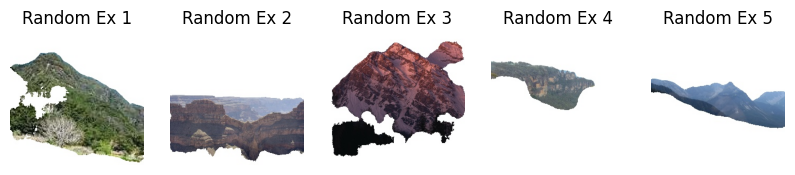

In [15]:
# code for displaying multiple images in one figure
import cv2
from matplotlib import pyplot as plt
import random

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 5

# Image 1
fig.add_subplot(rows, columns, 1)
plt.imshow(images[random.randint(0, 622)])
plt.axis('off')
plt.title("Random Ex 1")

# Image 2
fig.add_subplot(rows, columns, 2)
plt.imshow(images[random.randint(0, 622)])
plt.axis('off')
plt.title("Random Ex 2")

# Image 3
fig.add_subplot(rows, columns, 3)
plt.imshow(images[random.randint(0, 622)])
plt.axis('off')
plt.title("Random Ex 3")

# Image 4
fig.add_subplot(rows, columns, 4)
plt.imshow(images[random.randint(0, 622)])
plt.axis('off')
plt.title("Random Ex 4")

# Image 5
fig.add_subplot(rows, columns, 5)
plt.imshow(images[random.randint(0, 622)])
plt.axis('off')
plt.title("Random Ex 5");


In [16]:
# Load the captions as BERT embeddings
bert = pd.read_csv('/tmp/text-to-image-main/captions/bert_embeddings_with_processing_combined.csv')

In [17]:
bert.head()

,image,embeddings
0,0000000.png,"[-0.18654074, 0.09080678, -0.04873788, -0.1186..."
1,0000003.png,"[-0.42345372, -0.09363333, -0.091112725, -0.15..."
2,0000022.png,"[-0.0731625, 0.08338061, 0.06033717, -0.028062..."
3,0000027.png,"[-0.15718167, 0.051491044, -0.030174065, -0.05..."
4,0000032.png,"[-0.23134886, 0.03316869, -0.0654561, -0.26049..."


In [18]:
bert.shape

(623, 2)

In [19]:
# Shape of the embedding vector
import pandas as pd
import numpy as np
import ast

# Getting just the embeddings
embeddings_sent = bert['embeddings'][0]

# Using ast.literal_eval to convert string to list
embeddings_array = ast.literal_eval(embeddings_sent)
print("Size of the caption embedding = ", len(embeddings_array))
print(embeddings_array)

Size of the caption embedding =  768
[-0.18654074, 0.09080678, -0.04873788, -0.11867681, -0.09705621, -0.3768549, 0.37478364, 0.59343505, -0.20590413, -0.41474047, -0.34010303, -0.22697921, -0.0056033717, 0.2268956, 0.21337542, 0.3447809, -0.14834864, 0.70206517, 0.099709086, -0.06464473, 0.11380359, -0.2545349, 0.20150952, -0.09705969, 0.15682216, -0.07071307, -0.060880918, 0.2666134, 0.08554765, 0.07900312, -0.20769294, 0.2730134, -0.21611889, 0.0046359776, 0.37090284, -0.15145953, 0.13572305, 0.05338777, 0.29619193, 0.19924177, 0.131845, -0.012290475, 0.5728811, -0.061079133, 0.10663182, -0.63957775, -2.6005938, -0.09298431, -0.3775171, -0.33945125, 0.33016837, -0.11315736, 0.27860436, 0.1674585, 0.03730026, 0.8311566, 0.002084864, 0.49373946, 0.5225577, 0.3420205, 0.055324003, -0.174288, -0.77675253, 0.21529257, -0.16152133, 0.45756772, -0.36083642, -0.018395891, -0.196063, 0.35481602, -0.033727445, 0.61645234, 0.3737898, 0.017668542, -0.40288588, -0.3865365, -0.15890066, 0.2080488

https://docs.google.com/presentation/d/1TQVmcXG8IVp08KqRcwxnVpxPmeMIgJ5m/edit?usp=sharing&ouid=111109437597928732067&rtpof=true&sd=true

# Loading of Dataset

In [20]:
'''
def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_pah, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids
'''

'\ndef load_class_ids(class_info_file_path):\n    """\n    Load class ids from class_info.pickle file\n    """\n    with open(class_info_file_pah, \'rb\') as f:\n        class_ids = pickle.load(f, encoding=\'latin1\')\n        return class_ids\n'

In [ ]:
'''
class_info_file_path = '/content/class_info.pickle'
class_ids = load_class_ids(class_info_file_path)
print(class_ids)
'''

In [21]:
import numpy as np

def load_embeddings(embeddings_file_path):
    try:
        with open(embeddings_file_path, 'rb') as f:
            embeddings = pickle.load(f, encoding='latin1')
            embeddings_array = np.array(embeddings)
            return embeddings_array
    except pickle.UnpicklingError:
        print(f"Error: pickle data was truncated while reading {embeddings_file_path}")
        f = open(embeddings_file_path, 'rb')
        try:
            while True:
                embeddings = pickle.load(f, encoding='latin1')
                embeddings_array = np.array(embeddings)
        except EOFError:
            print(f"Successfully read {f.tell()} bytes of {embeddings_file_path}")
        finally:
            f.close()

In [22]:
embeddings_file_path = '/tmp/text-to-image-main/test-train/train/embedded_captions.pkl'
embeddings = load_embeddings(embeddings_file_path)

In [23]:
type(embeddings)

numpy.ndarray

In [ ]:
# for i in  :
#   current_embedding=embeddings[i:i+1,0]
#   print(current_embedding)

In [24]:
all_embeddings = embeddings[0:1, 1]
all_embeddings

array([array([-1.86540740e-01,  9.08067800e-02, -4.87378800e-02, -1.18676810e-01,
              -9.70562100e-02, -3.76854900e-01,  3.74783640e-01,  5.93435050e-01,
              -2.05904130e-01, -4.14740470e-01, -3.40103030e-01, -2.26979210e-01,
              -5.60337170e-03,  2.26895600e-01,  2.13375420e-01,  3.44780900e-01,
              -1.48348640e-01,  7.02065170e-01,  9.97090860e-02, -6.46447300e-02,
               1.13803590e-01, -2.54534900e-01,  2.01509520e-01, -9.70596900e-02,
               1.56822160e-01, -7.07130700e-02, -6.08809180e-02,  2.66613400e-01,
               8.55476500e-02,  7.90031200e-02, -2.07692940e-01,  2.73013400e-01,
              -2.16118890e-01,  4.63597760e-03,  3.70902840e-01, -1.51459530e-01,
               1.35723050e-01,  5.33877700e-02,  2.96191930e-01,  1.99241770e-01,
               1.31845000e-01, -1.22904750e-02,  5.72881100e-01, -6.10791330e-02,
               1.06631820e-01, -6.39577750e-01, -2.60059380e+00, -9.29843100e-02,
              -3

In [25]:
def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames

In [26]:
filenames_file_path = '/tmp/text-to-image-main/test-train/train/filenames.pickle'
files = load_filenames(filenames_file_path)
print(files)

['0000000.png', '0000003.png', '0000022.png', '0000027.png', '0000032.png', '0000034.png', '0000035.png', '0000036.png', '0000044.png', '0000045.png', '0000061.png', '0000063.png', '0000065.png', '0000069.png', '0000071.png', '0000073.png', '0000077.png', '0000078.png', '0000080.png', '0000081.png', '0000096.png', '0000100.png', '0000101.png', '0000110.png', '0000111.png', '0000124.png', '0000131.png', '0000149.png', '0000170.png', '0000182.png', '0000183.png', '0000188.png', '0000196.png', '0000204.png', '0000205.png', '0000207.png', '0000212.png', '0000217.png', '0000222.png', '0000234.png', '0000244.png', '0000256.png', '0000257.png', '0000258.png', '0000259.png', '0000263.png', '0000268.png', '0000280.png', '0000285.png', '0000298.png', '0000299.png', '0000303.png', '0000311.png', '0000315.png', '0000322.png', '0000336.png', '0000339.png', '0000343.png', '0000347.png', '0000367.png', '0022500.png', '0022504.png', '0022508.png', '0022509.png', '0022515.png', '0022521.png', '0022523.

In [27]:
def get_img(img_path, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize(image_size)
    return img

In [28]:
def load_dataset(filenames_file_path, embeddings_file_path, cub_dataset_dir, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        try:
           
            # Load images
            img_name = cub_dataset_dir + '/segmented_hills/'+ filename
            img = get_img(img_name, image_size)  
            # print(img)
            if(index!=623):
                # all_embeddings1 = embeddings[index:index+1, 1].to_numpy()
                # print("here"+all_embeddings1)
                # embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
                embedding = all_embeddings[index, :] #all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(index)  # Use index as class ID since we removed class_info_file_path
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    return X, y, embeddings

In [ ]:
# my version
'''
def load_dataset():
    dataset = []
    for i in range(len(files)):
        pair = {
            'caption': captions[i],
            'image': images[i]
        }
    dataset.append(pair)
'''

# Model Creation

In [29]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c

In [30]:
def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [31]:
def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [32]:
def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen


In [33]:
def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis

In [34]:
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(1024,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

# Defining Loss

In [35]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss

In [36]:

def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)


In [37]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

In [38]:
def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    # summary = tf.Summary()
    # summary_value = summary.value.add()
    # summary_value.simple_value = loss
    # summary_value.tag = name
    # callback.writer.add_summary(summary, batch_no)
    # callback.writer.flush()
  #Writer = tf.summary.create_file_writer(LOG_DIR)

    writer = tf.summary.create_file_writer("/tmp/mylogs")
    with writer.as_default():
      for step in range(100):
        # other model code would go here
        tf.summary.scalar("name", loss, step=step)
        writer.flush()

# Main File

In [58]:
if __name__ == '__main__':
    data_dir = "/tmp/text-to-image-main/test-train"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    image_size = 64
    batch_size = 256
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 3
    condition_dim = 128

    embeddings_file_path_train = train_dir + "/embedded_captions.pkl"
    embeddings_file_path_test = test_dir + "/embedded_captions.pkl"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    dataset_train = "/tmp/text-to-image-main/test-train/train/segmented_hills"
    dataset_test = "/tmp/text-to-image-main/test-train/test/segmented_hills"
    
    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """"
    Load datasets
    """
    # filenames_file_path, embeddings_file_path, cub_dataset_dir, image_size
    X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                      embeddings_file_path=embeddings_file_path_train,
                                                      cub_dataset_dir=dataset_train,
                                                      image_size=(64, 64))

    X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                   embeddings_file_path=embeddings_file_path_test,
                                                   cub_dataset_dir=dataset_test,
                                                   image_size=(64, 64))

    """
    Build and compile networks
    """
    ca_model = build_ca_model()
    ca_model.compile(loss="binary_crossentropy", optimizer="adam")

    stage1_dis = build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

    adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    # Generate an array containing real and fake values
    # Apply label smoothing as well
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))
            
            """
            Train the discriminator network
            """
            # # Sample a batch of data
            # z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            # image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # #embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            # embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size, 1]
            # print(embedding_batch.shape)
            # embedding_batch = embedding_batch.reshape((batch_size, 1))
            # embedding_batch = np.asarray(embedding_batch).astype('float32')
            

            # print(embedding_batch.shape)
            # #embedding_batch_new = embedding_batch.reshape(-1)
            # image_batch = (image_batch - 127.5) / 127.5

            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size, 1]  
            print(embedding_batch.shape)
            embedding_batch = np.asarray(embedding_batch.flatten()).astype('float32')
            print(embedding_batch.shape)

            # Reshape embedding_batch
            embedding_batch = np.reshape(embedding_batch, (batch_size, 1))
            print(embedding_batch.shape)
            image_batch = (image_batch - 127.5) / 127.5

           

            

            # Generate fake images
            # convert numpy array to a tensor
            # embedding_batch_tensor = tf.convert_to_tensor(embedding_batch)
            # fake_images, _ = stage1_gen.predict([embedding_batch_new, z_noise], verbose=3)

            # embedding_batch_new_tensor = tf.convert_to_tensor(embedding_batch_new)
            # z_noise_tensor = tf.convert_to_tensor(z_noise)

            
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network 
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch
        """
        #write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        #write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)
        '''
        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            # z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]
            fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "results/gen_{}_{}.png".format(epoch, i))
        '''
    # Save models
    stage1_gen.save_weights("stage1_gen.h5")
    stage1_dis.save_weights("stage1_dis.h5")

Embeddings shape: (435, 2)
Embeddings shape: (187, 2)
Epoch is: 0
Number of batches 1
Batch:1
(256,)


ValueError: ignored

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage1_dis.h5'})
uploaded.SetContentFile('stage1_dis.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage1_gen.h5'})
uploaded.SetContentFile('stage1_gen.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))